<a href="https://colab.research.google.com/github/h0806449f/TensorFlow/blob/main/Tibame_TensorFlow_TF(cat_vs_dog).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

上游任務 vs 下游任務
1. 上游 : 擷取圖片特徵
2. 下游 : 分類
3. 上游可以移植他人已經訓練好的模型 
    針對分類的類別, 再加上我們的任務需求
4. 特徵擷取 仍然需要與我方任務有關聯

In [22]:
# source
# model zoo : https://modelzoo.co/

In [23]:
# imagenet
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [24]:
import zipfile
path = "/content/drive/MyDrive/Learn/Deep Learn/_train.zip"
f = zipfile.ZipFile(path)
f.extractall()

(-0.5, 298.5, 224.5, -0.5)

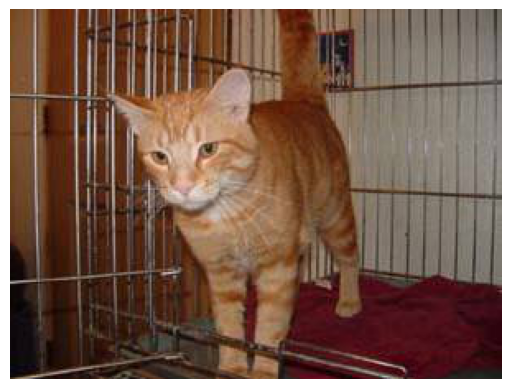

In [25]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

fs = glob.glob("train/*")

plt.imshow(Image.open(fs[2000]))
plt.axis("off")

In [26]:
import random
import pandas as pd

dogs = glob.glob("train/dog.*")
random.shuffle(dogs)

cats = glob.glob("train/cat.*")
random.shuffle(cats)

# 僅取特定數量 -> cat 1000 dog 1000
# 直接將資料分成三份 -> train 900+900 / validate 50+50 / test 50+50
# 轉 DataFrame

train = pd.DataFrame({
    "filename":dogs[:900] + cats[:900],
    "class":["dog"] * 900 + ["cat"] * 900
})
validate = pd.DataFrame({
    "filename":dogs[900:950] + cats[900:950],
    "class":["dog"] * 50 + ["cat"] * 50
})
test = pd.DataFrame({
    "filename":dogs[950:1000] + cats[950:1000],
    "class":["dog"] * 50 + ["cat"] * 50
})

In [27]:
# check DataFrame
train

,filename,class
0,train/dog.1350.jpg,dog
1,train/dog.803.jpg,dog
2,train/dog.11941.jpg,dog
3,train/dog.10039.jpg,dog
4,train/dog.4939.jpg,dog
...,...,...
1795,train/cat.4204.jpg,cat
1796,train/cat.3108.jpg,cat
1797,train/cat.6119.jpg,cat
1798,train/cat.6441.jpg,cat


In [28]:
# Generator Function (產生器)
r = range(50000000)  # r 是一個range物件
it = r.__iter__()   # __it__() 將r轉換為 : 跌代器物件

# 可以使用 __next__() 將range中的資料取出來
# 有跌代器物件後, 可以使用 __next__() 返回序列中的下一個值
it.__next__()
it.__next__()
it.__next__()

# 使用跌代器的目的 : 用於處理大型資料集 or 無窮序列
# 如果一次生成所有資料 -> ram癱瘓
# 可以理解為 for in ...

2

In [29]:
# Generator Function - yield
# 產生器函式使用yield語句來產生值, 而不是使用return
def test_return():
    l = [60, 70, 80, 90]
    for n in l:
        return n ** 2

def test_yield():
    l = [60, 70, 80, 90]
    for n in l:
        yield n ** 2

print(test_return())

for n in test_yield():  # test_yield 僅是一個產生器
    print(n)

3600
3600
4900
6400
8100


In [30]:
# Generator 於本案中的運用 -> 將圖片集中的路徑資料, 一個一個回傳

In [32]:
# https://keras.io/api/applications/
# 遷移學習哪一種模型, 就必須要使用該模型的 資料預處理方式 !!!
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# train資料 數據增強: zoom:放大(1,2) shear:偏斜(0,2) 水平翻轉
# 數據增強, 原始資料及數量不變。
# 而是即時生成轉換後的影像進入模型
train_datagenerator = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# test的資料 僅需做預處理
test_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_from_directory & flow_from_dataframe
# flow_from_dataframe: 檔案路徑一定要叫 filename / 答案一定要叫 class
train_set = train_datagenerator.flow_from_dataframe(
    train,            # dataframe名稱
    ".",             # 目前位置
    target_size=(224, 224),   # 每一張圖片縮到(224, 224) (根據當初imagenet的訓練大小)
    batch_size=32,        # 一次訓練32張
    class_mode="sparse"      # 自動將 dog / cat 字串 轉為0 / 1
)

test_set = test_datagenerator.flow_from_dataframe(
    test,
    ".",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

validate_set = test_datagenerator.flow_from_dataframe(
    validate,
    ".",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

Found 1800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


(32, 224, 224, 3)


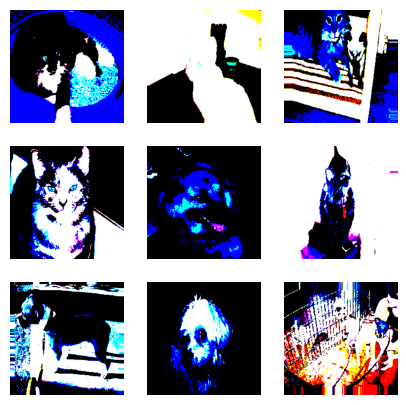

In [36]:
# 檢視 訓練資料被數據增強以後 的圖片
import matplotlib.pyplot as plt

# __next__ 會返回一個tuple (圖片, 答案)
batch = train_set.__next__()[0]  # 剛剛設定gererator一次會拿出32筆,這邊只取第1筆
print(batch.shape)   # (32, 224, 224, 3)

plt.figure(figsize=(5, 5))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis("off")

In [ ]:
# 從 4/29 影片開始